# TODO: добавить OHL к ценам и посмотреть другие метрики. Переписать алгоритм без YF и временно скрыть его

# Новый алгоритм

0. Сверяем файл с торгующимися на бирже акциями из файла pfc_all_active_stocks_april_2022.xlsx с торгующимися акциями по версии Мосбиржи из файла rates.csv. Мы будем делать все запросы именно по активным акциям, чтобы не тратить время на делистингованные компании;

1. Минутные данные ohlcv выгружаем с Yahoo Finance. Выгрузка происходит только по обыкновенным и привилегированным акциям российских компаний. Депозитарные расписки и акции иностранных компаний (Yandex и подобные) YF не выдает;

1.1 Проверка на all NaN ряды через ресэмпл в день. Дневные данные нужны только для проверки, сохранять их не будем;

1.2 Новые данные сохраняются в файл  ohlcv_minutes_upd.csv и дозаписываются в основной файл ohlcv_minutes_main.csv, который также потом сохраняется;


2. Дневные данные по цене закрытия и объему торгов в рублях всех акций и расписок выгружаем с МОЕХ через pandas-datareader;

2.1 Перемножаем маску объема (0 и 1) с ценамии, чтобы выставить NaN-цену для дня без объемов. ffill в исходнике применять не стоит;

2.1 Проверка на NaN-дни (в случае nan цены объем также будет nan, поэтому не повторяемся);

2.3 Новые данные перезаписываются в файлы moex_volume_rub.csv и moex_prices.csv

# Подводные камни

1. MOEX не выдает внутридневные данные;

2. YF не отдает данные по распискам и иностранным акциям;

3. Сплиты не учтены в данных. Сделай отдельный файл для перемножения с ценами

4. 5. Акции, которые числятся в списках инструментов на Мосбирже (csv-файл) и есть в торговом терминале брокера ПФК, но они уже точно делистингованы:


- ACKO, MFON, MORI, RUSP, TRCN, URKA, IRGZ

Акции, по которым найти информацию о делистинге не удалось, но сделок по ним не было очень давно.  Стаканы по ним также пусты:

- BISV, DERZP, GAZC, GAZS, GAZT, GTSS, HIMC, KMTZ, KRKO, KSGR, KZMS, NPOF, TRFM

Особый случай случай с ГДР, выпущенные на обыкновенные акции United Medical Group CY Plc по Правилу 144А https://www.moex.com/n35123/?nt=106

- По акции ЕМ44 за всю истории листинга сделок не было. Хотя брокер дал мне 28.04.22 выставить заявку на покупку по цене не ниже 39.5. Никто не продал :) Другой транш ГДР UMC торгуется нормально, его тикер - GEMC.

# Описание основного файла



2. Цена во всем исходном файле по дням - обычная цена закрытия, без дивидендов. Сплиты поправлены руками. Для всех типов акций. В идеале для дивидендов нужен отдельный файл. В теории, цены закрытия из всех источников должны совпадать, но д


3. Объемы торгов для обыкновенных и привилегированных российских компаний. С начала и до 2019-09-30 включительно - в рублях по данным брокера ПФК. Эти данные на незначительно отличаются от данных мосбиржи и довольно точны. С 2019-10-01 по 2019-04-13 включительно в рублях по данным YF. Расчитываются как объем в штуках акций за день * (Open+Close)/2. С 2019-04-14 по текущее время - это минутные объемы в штуках акций за день * (Open+Close)/2 по данным YF.


4. Объемы торгов по иностранным компаниям и АДР взяты с моех по итогам дня в рублях.



**Памятка про единицу измерения объема торгов из разных источников**

1) YF отдает данные в штуках акций

2) moex в штуках акций (VOLUME) и рублях (VALUE) на выбор;

3) ПФК в рублях (на копейки отличается от данных на сайте moex)

4) Refinitiv в тысячах акций. Тоже незначительно отличается от остальных

In [6]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
import os; os.chdir("..")
import pandas_datareader.data as web
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

Ворнинги по акциям при загрузке из YF:

1) **No data found for this date range, symbol may be delisted.** Торгов за указанный период не было. Это либо торгующийся на бирже неликвид, по которому именно за период не было сделок. Либо недавно делистингованная бумага, по которой еще хранится информация (RAVN)

2) **No data found, symbol may be delisted**. Акция делистингована давно (URKA) и никакой информации из YF уже не получить.

# 0 - Сравниваем текущий список инструментов с moex.com

В этом разделе сверяем список тикеров, которые выгружал в прошлый раз, с актуальным списком на Мосбирже. По итогам что-то добавляем и/или убираем

In [7]:
os.chdir('C:/Users/tomtosov/Desktop/data/russia/stocklists')

Открываем файл с нашили ликвидными, неликдными акциями и депозитарными расписками. Соединяем их тикеры вместе в один df

In [8]:
stock_list = pd.read_excel('all_active_stocks_dec_2022.xlsx')
stock_list = stock_list['Код инструмента'].sort_values(ascending = True)
stock_list.reset_index(inplace=True, drop=True)
stock_list

0       ABRD
1       AFKS
2       AFLT
3       AGRO
4       AKRN
       ...  
241     YNDX
242     YRSB
243    YRSBP
244     ZILL
245     ZVEZ
Name: Код инструмента, Length: 246, dtype: object

Загружаем файл с текущими инструментами фондового рынка. Параметры запроса: Т+: 

- Режим основных торгов 

- Акции обыкновенные

- Акции привилегированные

- РДР на акции (на апрель 2022 их 0, когда-то был Русал РДР)

- DR на иностранные акции (тут нужно исключить китайские и американские компании, пока их немного)

**Некоторые иностранные компании, которые субъективно считаю российскими (Яндекс и др.) в ручном режиме добавляются далее**

Или прямая ссылка:

https://www.moex.com/msn/stock-instruments#/?bg%5B%5D='stock_tplus'&sec_type%5B%5D='stock_russian_depositary_receipt','stock_foreign_share_dr','stock_common_share','stock_preferred_share'

Открываем файл:

In [9]:
moex_list = pd.read_csv('rates.csv', encoding='windows-1251', on_bad_lines='skip', skiprows=2, sep=';')
moex_list = moex_list['SECID']
moex_list

0       ABRD
1       ACKO
2       AFKS
3       AFLT
4       AGRO
       ...  
255    YKENP
256     YRSB
257    YRSBP
258     ZILL
259     ZVEZ
Name: SECID, Length: 260, dtype: object

Вручную добавляем иностранные компании, которые ведут свою деятельность в РФ (в основном). Изначально они сидят в разделе "Иностранные акции", но там 600+ тикеров иностранных акций.

In [10]:
foreign_rus = pd.Series(['YNDX', 'POGR', 'POLY', 'VEON-RX'])
moex_list = moex_list.append(foreign_rus)
moex_list

0         ABRD
1         ACKO
2         AFKS
3         AFLT
4         AGRO
        ...   
259       ZVEZ
0         YNDX
1         POGR
2         POLY
3      VEON-RX
Length: 264, dtype: object

Удаляем иностранные компании, которые имеют мало отношения к РФ, но сидят в разделе "DR на иностранные акции":

In [11]:
foreign_blacklist = ['BABA-RM', 'BIDU-RM', 'BILI-RM', 'JD-RM', 'LI-RM', 'MOMO-RM',
       'NIO-RM', 'NVS-RM', 'PTR-RM', 'SAP-RM', 'SONY-RM', 'TAL-RM',
       'TM-RM', 'TSM-RM', 'VIPS-RM', 'XPEV-RM']

Также удалим компании, которые уже не обращаются на Мосбирже, либо сделок по ним не было несколько лет, но которые числятся в списке тикеров. В терминале ПФК они тоже есть, но из файла pfc_all_active_stocks_april_2022.xlsx я уже удалил их вручную

In [12]:
dead_but_on_moex = ['ACKO', 'BISV', 'DERZP', 'GAZC', 'GAZS', 'GAZT', 'GTSS', 'HIMC',
       'IRGZ', 'KMTZ', 'KRKO', 'KSGR', 'KZMS', 'MFON', 'MORI', 'NPOF',
       'RUSP', 'TRCN', 'TRFM', 'URKA']

In [13]:
moex_list = moex_list[~moex_list.isin(foreign_blacklist)]
moex_list = moex_list[~moex_list.isin(dead_but_on_moex)]
moex_list = moex_list.sort_values(ascending = True)
moex_list

0       ABRD
2       AFKS
3       AFLT
4       AGRO
5       AKRN
       ...  
0       YNDX
256     YRSB
257    YRSBP
258     ZILL
259     ZVEZ
Length: 243, dtype: object

Кто был в базе, но пропал из инструментов МОЕХ:

In [14]:
np.setdiff1d(stock_list, moex_list)

array(['RSTI', 'RSTIP', 'RUGR'], dtype=object)

**Удалить эти акции из списка живых инструментов, в истории они остануться**

**TODO: delete RSTI and RSTIP. They are already downloaded until last date**

Кто не был в базе, но появился в МОЕХ:

**Эти акции добавить в список всех живых инструментов**

In [15]:
np.setdiff1d(moex_list, stock_list)

array([], dtype=object)

**29.11.22 - С RUGR очевидный баг, котировки идут, но Мосбиржа из списка акции удалила**

**17.01.23 - баг с RUGR сохраняется. Торги идут и с моекса котровки выкачиваются, но в списке на сайте тикер отсутствует**

**9.01.23 перестали торговаться акции Россетей RSTI и RSTIP. Произошла конвертация в акции FEES**

# 2 - Выгружаем дневные данные по цене и объему в рублях с МОЕХ

In [16]:
daily_start = '2022-12-16'
daily_end = '2023-01-16'

In [17]:
stock_list[0]

'ABRD'

In [19]:
moex_request = web.DataReader(stock_list[0], 'moex', daily_start, daily_end)
moex_request

,ACCINT,ADMITTEDQUOTE,ADMITTEDVALUE,BEICLOSE,BID,BOARDID,BOARDNAME,BUYBACKDATE,CBRCLOSE,CLOSE,...,TRENDWAPPR,TYPE,VALUE,VOLUME,WAPRICE,WAVAL,YIELDATWAP,YIELDCLOSE,YIELDLASTCOUPON,YIELDTOOFFER
TRADEDATE,,,,,,,,,,,,,,,,,,,,,
2022-12-16,NaN,185.0,14140045.0,NaN,NaN,TQBR,NaN,NaN,NaN,185.0,...,NaN,NaN,14140045.0,76390.0,185.0,0.0,NaN,NaN,NaN,NaN
2022-12-19,NaN,189.0,21739705.0,NaN,NaN,TQBR,NaN,NaN,NaN,189.0,...,NaN,NaN,21739705.0,116280.0,187.0,0.0,NaN,NaN,NaN,NaN
2022-12-20,NaN,191.5,18751535.0,NaN,NaN,TQBR,NaN,NaN,NaN,191.5,...,NaN,NaN,18751535.0,97880.0,191.5,0.0,NaN,NaN,NaN,NaN
2022-12-21,NaN,190.0,8913795.0,NaN,NaN,TQBR,NaN,NaN,NaN,190.0,...,NaN,NaN,8913795.0,46730.0,191.0,0.0,NaN,NaN,NaN,NaN
2022-12-22,NaN,193.0,21534555.0,NaN,NaN,TQBR,NaN,NaN,NaN,193.0,...,NaN,NaN,21534555.0,111350.0,193.5,0.0,NaN,NaN,NaN,NaN
2022-12-23,NaN,191.5,96573965.0,NaN,NaN,TQBR,NaN,NaN,NaN,191.5,...,NaN,NaN,96573965.0,489440.0,197.5,0.0,NaN,NaN,NaN,NaN
2022-12-26,NaN,193.0,38009235.0,NaN,NaN,TQBR,NaN,NaN,NaN,193.0,...,NaN,NaN,38009235.0,196100.0,194.0,0.0,NaN,NaN,NaN,NaN
2022-12-27,NaN,200.0,122498695.0,NaN,NaN,TQBR,NaN,NaN,NaN,200.0,...,NaN,NaN,122498695.0,609640.0,201.0,0.0,NaN,NaN,NaN,NaN
2022-12-28,NaN,196.0,41242045.0,NaN,NaN,TQBR,NaN,NaN,NaN,196.0,...,NaN,NaN,41242045.0,207950.0,198.5,0.0,NaN,NaN,NaN,NaN


Обрати внимание, что по EM44 обычно нет торгов и такой столбец не создается. Добавим в его цены вручную NaN, а в объемы 0. Если количество столбцов не совпадает с тикерами, значит по ЕМ есть котировка и NaN/0 добавлять не нужно

Сразу присвоим таблице индекс из дневных данных по YF, чтобы легче потом замерджить

In [20]:
import time

second_iteration = []

for i in tqdm(range(len(stock_list[1:]))):
    
    try:
        
        request = web.DataReader(stock_list[i+1], 'moex', daily_start, daily_end)
        moex_request = pd.concat([moex_request, request], axis=0)
        
    except:
        time.sleep(1)
        print(stock_list[i+1])
        second_iteration.append(stock_list[i+1])

100%|████████████████████████████████████████████████████████████████████████████████| 245/245 [10:06<00:00,  2.48s/it]


Для тех, кто не скачался, делаем отдельный запрос. Каждый раз это какие-то разные бумаги. Видимо баг

In [55]:
for i in tqdm(range(len(second_iteration))):
    
    try:
        request = web.DataReader(second_iteration[i], 'moex', daily_start, daily_end)
        moex_request = pd.concat([moex_request, request], axis=0)
    except:
        time.sleep(1)
        print(second_iteration[i])

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.23it/s]


In [21]:
rus_new_price = moex_request.pivot_table(index='TRADEDATE', columns='SECID', values='CLOSE')
rus_new_price.columns.name = None
rus_new_price.index.name = 'Date'
rus_new_price

,ABRD,AFKS,AFLT,AGRO,AKRN,ALRS,AMEZ,APTK,AQUA,ARSA,...,WTCMP,WUSH,YAKG,YKEN,YKENP,YNDX,YRSB,YRSBP,ZILL,ZVEZ
Date,,,,,,,,,,,,,,,,,,,,,
2022-12-16,185.0,11.969,24.24,665.6,17998.0,60.90,26.335,11.510,603.5,5.08,...,6.14,155.00,112.70,0.2640,0.2595,1836.4,172.0,83.0,2025.0,3.440
2022-12-19,189.0,11.640,23.94,653.0,17998.0,59.89,26.380,11.450,581.0,4.93,...,6.14,159.13,113.45,0.2595,0.2590,1768.8,170.0,81.0,2040.0,3.445
2022-12-20,191.5,12.229,24.12,661.0,18180.0,60.16,26.390,11.400,587.5,5.00,...,6.22,160.48,116.25,0.2620,0.2595,1842.0,172.0,82.0,2015.0,3.540
2022-12-21,190.0,12.050,24.06,682.0,18212.0,59.49,26.630,11.368,601.5,4.99,...,6.24,160.67,117.60,0.2635,0.2580,1833.8,172.0,80.5,2050.0,3.565
2022-12-22,193.0,12.291,24.18,672.8,18172.0,59.22,27.150,11.456,600.5,5.01,...,6.22,159.40,118.20,0.2620,0.2590,1847.0,176.0,84.0,2050.0,3.735
2022-12-23,191.5,12.040,24.22,673.0,18146.0,59.20,26.710,11.700,599.0,5.06,...,6.22,158.00,118.80,0.2640,0.2585,1821.2,174.0,84.5,2085.0,3.750
2022-12-26,193.0,12.010,24.46,670.2,18092.0,59.31,28.880,11.896,601.5,5.05,...,6.32,165.00,118.70,0.2615,0.2580,1811.4,172.0,83.5,2125.0,3.750
2022-12-27,200.0,11.988,24.32,667.0,18100.0,59.11,28.985,11.748,599.5,5.06,...,6.38,162.70,120.00,0.2610,0.2575,1834.0,172.0,83.0,2135.0,3.780
2022-12-28,196.0,11.900,24.18,661.0,18090.0,58.22,27.890,11.646,599.0,4.90,...,6.52,164.83,129.90,0.2585,0.2590,1815.8,174.0,81.0,2150.0,3.665


In [22]:
rus_new_volume = moex_request.pivot_table(index='TRADEDATE', columns='SECID', values='VALUE')
rus_new_volume.columns.name = None
rus_new_volume.index.name = 'Date'
rus_new_volume

,ABRD,AFKS,AFLT,AGRO,AKRN,ALRS,AMEZ,APTK,AQUA,ARSA,...,WTCMP,WUSH,YAKG,YKEN,YKENP,YNDX,YRSB,YRSBP,ZILL,ZVEZ
Date,,,,,,,,,,,,,,,,,,,,,
2022-12-16,14140045.0,135420074.6,57026815.4,39148324.6,21087796.0,3.336487e+08,4.825771e+06,576745.00,14698339.0,411241.0,...,886004.0,4.403811e+08,3251878.5,47405.0,44150.0,4.715637e+08,8580.0,60150.0,238060.0,450550.0
2022-12-19,21739705.0,213236323.6,86902993.2,36026381.6,10971568.0,5.525011e+08,5.401964e+06,915127.74,17463458.5,302285.0,...,62800.0,1.696767e+08,1112749.5,58065.0,7775.0,1.049989e+09,94120.0,19665.0,1237255.0,440380.0
2022-12-20,18751535.0,235077376.5,143531464.0,47765874.0,30771384.0,9.222593e+08,4.206000e+06,1786728.46,12516041.0,492430.0,...,89850.0,3.756684e+07,1840525.0,44165.0,38675.0,9.233832e+08,43180.0,12250.0,111760.0,261290.0
2022-12-21,8913795.0,156078272.5,91915765.0,119286411.6,24714264.0,5.953983e+08,1.075379e+07,1412585.20,13254671.5,389758.0,...,104874.0,6.385569e+07,1580693.5,201485.0,57335.0,9.574092e+08,6860.0,19355.0,592455.0,96275.0
2022-12-22,21534555.0,168282265.9,72986023.4,60125298.4,10714074.0,4.841975e+08,1.320950e+07,1800434.72,14951658.5,305110.0,...,177560.0,1.862051e+07,1587198.5,115290.0,99485.0,7.818359e+08,166780.0,104035.0,7139010.0,1137730.0
2022-12-23,96573965.0,123882264.1,128689776.0,28817040.8,16774344.0,3.488291e+08,5.646487e+08,77973080.12,5469327.0,124634.0,...,176940.0,1.138103e+07,584689.5,55455.0,67270.0,7.320285e+08,17560.0,23495.0,583275.0,431040.0
2022-12-26,38009235.0,178388429.6,99438788.6,32680690.8,12683902.0,4.183174e+08,3.397581e+08,9703340.90,10782722.0,253510.0,...,265200.0,9.987640e+07,1775536.5,54540.0,20655.0,7.134287e+08,60660.0,116875.0,420420.0,297865.0
2022-12-27,122498695.0,121394333.0,85720284.4,43054065.6,11023808.0,5.277256e+08,1.257319e+08,3809960.10,14011648.5,298248.0,...,1011676.0,2.002150e+07,627239.0,23460.0,15515.0,6.509296e+08,22380.0,4945.0,224010.0,203760.0
2022-12-28,41242045.0,168827120.5,163818301.2,34953593.4,23513706.0,8.934984e+08,4.751622e+07,4732528.22,11467695.0,519282.0,...,170088.0,1.303502e+07,42041015.0,18165.0,10335.0,6.380156e+08,17400.0,26865.0,327105.0,290780.0


# 2.1 Маска объема

In [23]:
rus_new_volume.replace(0, np.nan, inplace=True)

volume_mask = rus_new_volume.copy()
volume_mask[volume_mask>0] = 1

rus_new_price = rus_new_price * volume_mask
rus_new_price

,ABRD,AFKS,AFLT,AGRO,AKRN,ALRS,AMEZ,APTK,AQUA,ARSA,...,WTCMP,WUSH,YAKG,YKEN,YKENP,YNDX,YRSB,YRSBP,ZILL,ZVEZ
Date,,,,,,,,,,,,,,,,,,,,,
2022-12-16,185.0,11.969,24.24,665.6,17998.0,60.90,26.335,11.510,603.5,5.08,...,6.14,155.00,112.70,0.2640,0.2595,1836.4,172.0,83.0,2025.0,3.440
2022-12-19,189.0,11.640,23.94,653.0,17998.0,59.89,26.380,11.450,581.0,4.93,...,6.14,159.13,113.45,0.2595,0.2590,1768.8,170.0,81.0,2040.0,3.445
2022-12-20,191.5,12.229,24.12,661.0,18180.0,60.16,26.390,11.400,587.5,5.00,...,6.22,160.48,116.25,0.2620,0.2595,1842.0,172.0,82.0,2015.0,3.540
2022-12-21,190.0,12.050,24.06,682.0,18212.0,59.49,26.630,11.368,601.5,4.99,...,6.24,160.67,117.60,0.2635,0.2580,1833.8,172.0,80.5,2050.0,3.565
2022-12-22,193.0,12.291,24.18,672.8,18172.0,59.22,27.150,11.456,600.5,5.01,...,6.22,159.40,118.20,0.2620,0.2590,1847.0,176.0,84.0,2050.0,3.735
2022-12-23,191.5,12.040,24.22,673.0,18146.0,59.20,26.710,11.700,599.0,5.06,...,6.22,158.00,118.80,0.2640,0.2585,1821.2,174.0,84.5,2085.0,3.750
2022-12-26,193.0,12.010,24.46,670.2,18092.0,59.31,28.880,11.896,601.5,5.05,...,6.32,165.00,118.70,0.2615,0.2580,1811.4,172.0,83.5,2125.0,3.750
2022-12-27,200.0,11.988,24.32,667.0,18100.0,59.11,28.985,11.748,599.5,5.06,...,6.38,162.70,120.00,0.2610,0.2575,1834.0,172.0,83.0,2135.0,3.780
2022-12-28,196.0,11.900,24.18,661.0,18090.0,58.22,27.890,11.646,599.0,4.90,...,6.52,164.83,129.90,0.2585,0.2590,1815.8,174.0,81.0,2150.0,3.665


In [24]:
print(rus_new_volume.shape, rus_new_price.shape)

(21, 245) (21, 245)


# 2.2 Проверка NaN цен

In [25]:
rus_new_price[rus_new_price.columns[rus_new_price.isna().any()]]

,FEES,KCHE,KCHEP,MGNZ,ROLO,RSTI,RSTIP,RTGZ,TGKD,TGKDP,YKENP
Date,,,,,,,,,,,
2022-12-16,0.08494,0.1720,NaN,NaN,7.550,0.5623,1.108,NaN,NaN,NaN,0.2595
2022-12-19,0.08376,NaN,0.302,NaN,7.820,0.5533,1.094,23600.0,NaN,NaN,0.2590
2022-12-20,0.08634,0.1710,0.302,NaN,7.705,0.5588,1.123,23500.0,NaN,NaN,0.2595
2022-12-21,NaN,0.1715,0.302,NaN,7.660,NaN,NaN,NaN,NaN,NaN,0.2580
2022-12-22,NaN,0.1720,0.308,NaN,7.785,NaN,NaN,23300.0,NaN,NaN,0.2590
2022-12-23,NaN,0.1725,0.311,NaN,NaN,NaN,NaN,23200.0,NaN,NaN,0.2585
2022-12-26,NaN,0.1725,0.309,NaN,7.640,NaN,NaN,23300.0,NaN,NaN,0.2580
2022-12-27,NaN,0.1710,0.310,NaN,7.635,NaN,NaN,23600.0,NaN,NaN,0.2575
2022-12-28,NaN,0.1725,NaN,NaN,7.485,NaN,NaN,NaN,NaN,NaN,0.2590


# 2.3 Соединяем с основным файлом и сохраняем

In [26]:
rus_prices = pd.read_csv('C:/Users/tomtosov/Desktop/data/russia/close_price/moex_prices.csv', index_col=0)
rus_volume = pd.read_csv('C:/Users/tomtosov/Desktop/data/russia/volume/moex_volume_rub.csv', index_col=0)

rus_prices

,ABRD,ACKO,AESL,AFKS,AFLT,AGRO,AKHA,AKRN,ALBK,ALNU,...,YRSL,YUKO,ZAGR,ZHIV,ZILL,ZMZN,ZMZNP,ZOYA,ZVEZ,WUSH
Date,,,,,,,,,,,,,,,,,,,,,
1999-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-07-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-07-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-07-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-07-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-09,187.5,NaN,NaN,12.447,24.70,690.2,NaN,18070.0,NaN,NaN,...,NaN,NaN,NaN,NaN,1950.0,NaN,NaN,NaN,3.680,NaN
2022-12-12,187.0,NaN,NaN,12.347,24.76,695.8,NaN,18004.0,NaN,NaN,...,NaN,NaN,NaN,NaN,1965.0,NaN,NaN,NaN,3.690,NaN
2022-12-13,188.5,NaN,NaN,12.258,24.60,683.6,NaN,18026.0,NaN,NaN,...,NaN,NaN,NaN,NaN,1995.0,NaN,NaN,NaN,3.670,NaN


In [27]:
rus_prices = pd.concat([rus_prices, rus_new_price], axis=0)
rus_prices.index = pd.to_datetime(rus_prices.index)
rus_prices

,ABRD,ACKO,AESL,AFKS,AFLT,AGRO,AKHA,AKRN,ALBK,ALNU,...,YRSL,YUKO,ZAGR,ZHIV,ZILL,ZMZN,ZMZNP,ZOYA,ZVEZ,WUSH
Date,,,,,,,,,,,,,,,,,,,,,
1999-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-07-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-07-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-07-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-07-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-10,193.0,NaN,NaN,11.876,26.72,680.0,NaN,18064.0,NaN,NaN,...,NaN,NaN,NaN,NaN,2200.0,NaN,NaN,NaN,3.785,163.97
2023-01-11,194.5,NaN,NaN,12.137,27.68,686.4,NaN,17992.0,NaN,NaN,...,NaN,NaN,NaN,NaN,2175.0,NaN,NaN,NaN,3.860,162.87
2023-01-12,196.5,NaN,NaN,12.086,27.52,682.0,NaN,17980.0,NaN,NaN,...,NaN,NaN,NaN,NaN,2170.0,NaN,NaN,NaN,3.965,162.59


Объем

In [28]:
rus_volume = pd.concat([rus_volume, rus_new_volume], axis=0)
rus_volume.index = pd.to_datetime(rus_volume.index)
rus_volume

,ABRD,ACKO,AESL,AFKS,AFLT,AGRO,AKHA,AKRN,ALBK,ALNU,...,YRSL,YUKO,ZAGR,ZHIV,ZILL,ZMZN,ZMZNP,ZOYA,ZVEZ,WUSH
Date,,,,,,,,,,,,,,,,,,,,,
1999-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-07-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-07-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-07-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-07-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-10,7410745.0,NaN,NaN,116752203.7,376721030.8,31842676.2,NaN,12823128.0,NaN,NaN,...,NaN,NaN,NaN,NaN,1196830.0,NaN,NaN,NaN,917105.0,24743959.15
2023-01-11,11308185.0,NaN,NaN,238994979.3,564354912.0,48268460.8,NaN,10339660.0,NaN,NaN,...,NaN,NaN,NaN,NaN,593560.0,NaN,NaN,NaN,1678260.0,19615993.29
2023-01-12,81421820.0,NaN,NaN,205434772.3,343613720.4,18885815.2,NaN,21564566.0,NaN,NaN,...,NaN,NaN,NaN,NaN,864290.0,NaN,NaN,NaN,1791880.0,8027830.75


In [30]:
rus_prices.to_csv('C:/Users/tomtosov/Desktop/data/russia/close_price/moex_prices.csv')
rus_volume.to_csv('C:/Users/tomtosov/Desktop/data/russia/volume/moex_volume_rub.csv')

In [88]:
rus_prices['TGKD'][-100:-50]

Date
2022-08-26    0.012795
2022-08-29    0.012805
2022-08-30    0.012900
2022-08-31    0.012850
2022-09-01    0.012850
2022-09-02    0.012885
2022-09-05    0.012860
2022-09-06    0.012900
2022-09-07    0.012920
2022-09-08    0.012905
2022-09-09    0.012880
2022-09-12    0.012905
2022-09-13    0.012945
2022-09-14         NaN
2022-09-15         NaN
2022-09-16         NaN
2022-09-19         NaN
2022-09-20         NaN
2022-09-21         NaN
2022-09-22         NaN
2022-09-23         NaN
2022-09-26         NaN
2022-09-27         NaN
2022-09-28         NaN
2022-09-29         NaN
2022-09-30         NaN
2022-10-03         NaN
2022-10-04         NaN
2022-10-05         NaN
2022-10-06         NaN
2022-10-07         NaN
2022-10-10         NaN
2022-10-11         NaN
2022-10-12         NaN
2022-10-13         NaN
2022-10-14         NaN
2022-10-17         NaN
2022-10-18         NaN
2022-10-19         NaN
2022-10-20         NaN
2022-10-21         NaN
2022-10-24         NaN
2022-10-25         NaN
2022-1

In [32]:
rus_volume['MGNZ'].tail(50)

Date
2022-11-07    1363470.0
2022-11-08          NaN
2022-11-09          NaN
2022-11-10          NaN
2022-11-11          NaN
2022-11-14          NaN
2022-11-15          NaN
2022-11-16          NaN
2022-11-17          NaN
2022-11-18          NaN
2022-11-21          NaN
2022-11-22          NaN
2022-11-23          NaN
2022-11-24          NaN
2022-11-25          NaN
2022-11-28          NaN
2022-11-29          NaN
2022-11-30          NaN
2022-12-01          NaN
2022-12-02          NaN
2022-12-05          NaN
2022-12-06          NaN
2022-12-07          NaN
2022-12-08          NaN
2022-12-09          NaN
2022-12-12          NaN
2022-12-13          NaN
2022-12-14          NaN
2022-12-15          NaN
2022-12-16          NaN
2022-12-19          NaN
2022-12-20          NaN
2022-12-21          NaN
2022-12-22          NaN
2022-12-23          NaN
2022-12-26          NaN
2022-12-27          NaN
2022-12-28          NaN
2022-12-29          NaN
2022-12-30          NaN
2023-01-03          NaN
2023-01-04 

In [364]:
print(rus_prices.columns.tolist())

['ABRD', 'ACKO', 'AESL', 'AFKS', 'AFLT', 'AGRO', 'AKHA', 'AKRN', 'ALBK', 'ALNU', 'ALRS', 'AMEZ', 'APDS', 'APDSP', 'APTK', 'AQUA', 'ARHE', 'ARHEP', 'ARMD', 'ARSA', 'ARSB', 'ARSBP', 'ASRE', 'ASSB', 'AVAN', 'AVAZ', 'AVAZP', 'AZKM', 'BACT', 'BANE', 'BANEP', 'BEGY', 'BEGYP', 'BELU', 'BENR', 'BENRP', 'BFMA', 'BGDE', 'BISV', 'BISVP', 'BLNG', 'BLRS', 'BLRSP', 'BLSB', 'BLSBP', 'BNSB', 'BNSBP', 'BREN', 'BRENP', 'BRZL', 'BSPB', 'BSPBP', 'BUSB', 'CBOM', 'CHEP', 'CHGZ', 'CHKZ', 'CHMF', 'CHMK', 'CHNG', 'CHNGP', 'CHSB', 'CHSBP', 'CHZN', 'CIAN', 'CLSB', 'CLSBP', 'CMST', 'CNTL', 'CNTLP', 'CTLK', 'CTLKP', 'DAGR', 'DASB', 'DGBZ', 'DGBZP', 'DGEN', 'DIKO', 'DIOD', 'DIXY', 'DLSV', 'DLSVP', 'DLVB', 'DNKOP', 'DSKY', 'DVEC', 'DZRD', 'DZRDP', 'EELT', 'EESR', 'EESRP', 'ELTZ', 'EM44', 'ENPG', 'ENPL', 'ENRU', 'EONR', 'EPLN', 'ERMK', 'ETGK', 'ETLN', 'EVCO', 'FCIN', 'FEES', 'FESH', 'FIVE', 'FIXP', 'FLKO', 'FLOT', 'FTRE', 'GAZA', 'GAZAP', 'GAZC', 'GAZP', 'GAZT', 'GCHE', 'GEMA', 'GEMC', 'GLTR', 'GMKN', 'GRAZ', 'GRNT',

<AxesSubplot:xlabel='Date'>

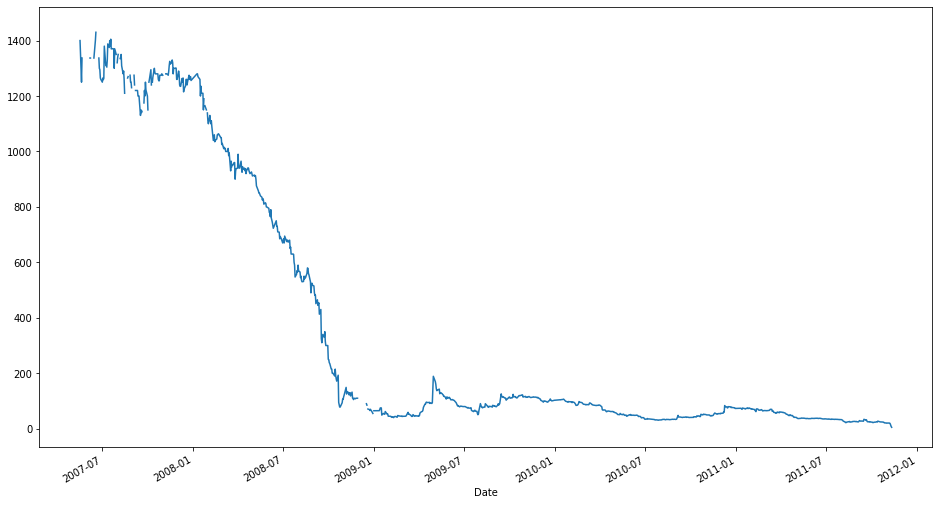

In [414]:
rus_prices['KLNA'].plot()

In [400]:
rus_prices['ROSB'].tail(50)

Date
2022-11-07    103.2
2022-11-08    104.4
2022-11-09    102.6
2022-11-10    105.8
2022-11-11    104.0
2022-11-14    105.4
2022-11-15    105.0
2022-11-16    104.2
2022-11-17    106.4
2022-11-18    105.8
2022-11-21    106.0
2022-11-22    107.2
2022-11-23    107.0
2022-11-24    107.4
2022-11-25    107.6
2022-11-28    107.0
2022-11-29    107.4
2022-11-30    107.6
2022-12-01    106.8
2022-12-02    107.0
2022-12-05    107.4
2022-12-06    107.0
2022-12-07    107.0
2022-12-08    107.2
2022-12-09    107.2
2022-12-12    107.2
2022-12-13    107.2
2022-12-14    108.0
2022-12-15    107.8
2022-12-16    107.6
2022-12-19    108.0
2022-12-20    108.0
2022-12-21    108.2
2022-12-22    108.0
2022-12-23    107.6
2022-12-26    107.8
2022-12-27    107.8
2022-12-28    107.8
2022-12-29    107.8
2022-12-30    108.0
2023-01-03    108.8
2023-01-04    108.4
2023-01-05    108.0
2023-01-06    109.0
2023-01-09    109.6
2023-01-10    109.4
2023-01-11    109.0
2023-01-12    108.6
2023-01-13    108.8
2023-01-16    1